In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


### load dataset

In [2]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.tensorflow.data import _parse_function

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

In [4]:
print(tf.__version__, tfp.__version__)

2.0.0-beta1 0.7.0-dev20190510


In [5]:
TRAIN_SIZE=101726
BATCH_SIZE=32
TEST_SIZE=10000
DIMS = (32, 32, 1)
N_TRAIN_BATCHES =int((TRAIN_SIZE-TEST_SIZE)/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_SIZE/BATCH_SIZE)
TRAIN_BUF = 1000
TEST_BUF = 1000

In [6]:
DATASET_ID = 'starling'

In [7]:
record_loc = DATA_DIR / 'tfrecords' / "starling_32.tfrecords"

In [8]:
# read the dataset
raw_dataset = tf.data.TFRecordDataset([record_loc.as_posix()])

In [9]:
data_types = {
    "spectrogram": tf.uint8,
    "index": tf.int64,
    "indv": tf.string,
}

In [10]:
# parse each data type to the raw dataset
dataset = raw_dataset.map(lambda x: _parse_function(x, data_types=data_types))

In [11]:
spec, index, indv  = next(iter(dataset))

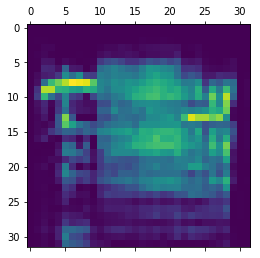

In [12]:
plt.matshow(spec.numpy().reshape(DIMS[:2]))

In [13]:
test_dataset = dataset.take(TEST_SIZE).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
train_dataset = dataset.skip(TEST_SIZE).take(TRAIN_SIZE-TEST_SIZE).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [14]:
# exampled data for plotting results
example_data = next(iter(test_dataset))
example_data = (
        tf.cast(tf.reshape(example_data[0], [BATCH_SIZE] + list(DIMS)), tf.float32)
        / 255
)

In [15]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(32, 32, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [16]:
optimizer = tf.keras.optimizers.Adam(1e-2)


def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(
        -0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + log2pi), axis=raxis
    )


@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [17]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim]
)
model = CVAE(latent_dim)

In [18]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap="gray")
        plt.axis("off")

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.show()

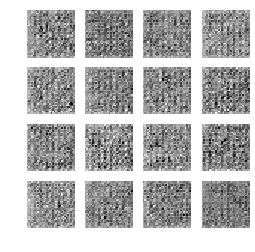

In [19]:
generate_and_save_images(model, 0, random_vector_for_generation)


In [20]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL

from IPython import display

Epoch: 24, Test set ELBO: -275.3623046875, time elapse for current epoch 7.358217477798462


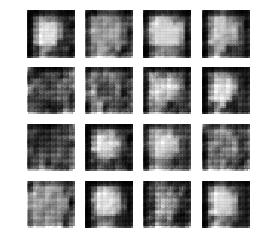

KeyboardInterrupt: 

In [21]:
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        x = tf.cast(tf.reshape(train_x[0], [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
        #x = x *tf.cast(x > .25, tf.float32)
    compute_apply_gradients(model, x, optimizer)
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        x = tf.cast(tf.reshape(test_x[0], [BATCH_SIZE] + list(DIMS)), tf.float32) / 255
        #x = x *tf.cast(x > .25, tf.float32)
        loss(compute_loss(model, x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print(
        "Epoch: {}, Test set ELBO: {}, "
        "time elapse for current epoch {}".format(epoch, elbo, end_time - start_time)
    )
    generate_and_save_images(model, epoch, random_vector_for_generation)

In [22]:
mean, logvar = model.encode(x)

(array([ 96., 152., 200., 159., 215., 138., 249., 167.,  91., 133.]),
 array([-0.6896899 , -0.5610529 , -0.43241602, -0.3037791 , -0.17514217,
        -0.04650524,  0.08213168,  0.21076861,  0.33940554,  0.46804246,
         0.5966794 ], dtype=float32),
 <a list of 10 Patch objects>)

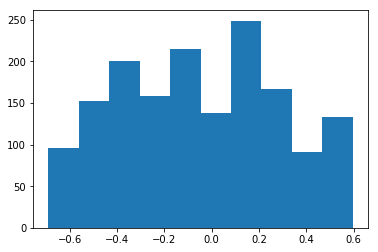

In [23]:
plt.hist(mean.numpy().flatten())

(array([ 78., 109.,  69., 104., 278., 443., 263., 136.,  88.,  32.]),
 array([-0.33972606, -0.28320727, -0.22668846, -0.17016965, -0.11365084,
        -0.05713204, -0.00061324,  0.05590557,  0.11242437,  0.16894317,
         0.22546197], dtype=float32),
 <a list of 10 Patch objects>)

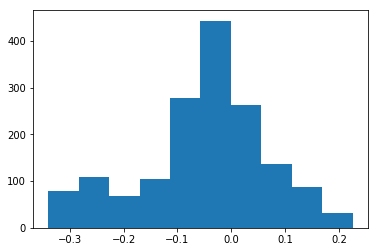

In [24]:
plt.hist(logvar.numpy().flatten())

In [25]:
reparam = model.reparameterize(mean, logvar)

(array([ 13.,  35., 138., 301., 380., 368., 248.,  83.,  28.,   6.]),
 array([-3.2273552 , -2.5748534 , -1.9223515 , -1.2698495 , -0.61734766,
         0.03515422,  0.6876561 ,  1.340158  ,  1.9926599 ,  2.6451619 ,
         3.2976637 ], dtype=float32),
 <a list of 10 Patch objects>)

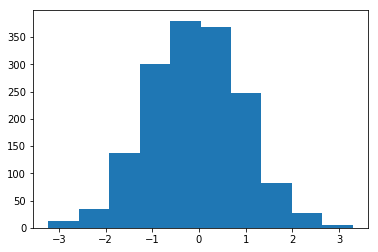

In [26]:
plt.hist(reparam.numpy().flatten())

In [27]:
mean, logvar = model.encode(x)
z = model.reparameterize(mean, logvar)
x_logit = model.decode(z)

cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
logpz = log_normal_pdf(z, 0.0, 0.0)
logqz_x = log_normal_pdf(z, mean, logvar)

In [34]:
-tf.reduce_mean(logpx_z + logpz - logqz_x)

<tf.Tensor: id=688335, shape=(), dtype=float32, numpy=248.29681>

In [36]:
logpx_z

<tf.Tensor: id=688294, shape=(32,), dtype=float32, numpy=
array([-200.56567, -247.12935, -310.48563, -192.60835, -202.20753,
       -218.91127, -341.4844 , -298.54755, -241.8484 , -346.97726,
       -261.05472, -200.77899, -278.59125, -235.77126, -299.6037 ,
       -322.9155 , -409.795  , -309.09293, -168.24312, -275.43463,
       -187.51398, -159.73502, -214.52208, -194.5543 , -231.79553,
       -319.15533, -210.54677, -166.37947, -168.19347, -225.1467 ,
       -210.91801, -203.05592], dtype=float32)>

In [35]:
logpz - logqz_x

<tf.Tensor: id=688337, shape=(32,), dtype=float32, numpy=
array([-2.9619827 , -2.1143875 , -2.4586868 , -0.6816025 , -3.9445915 ,
       -2.4916382 , -5.7020874 , -7.313797  , -5.2303467 , -0.663208  ,
       -2.107109  , -3.623726  , -0.98574066, -0.34575653, -3.8254547 ,
       -2.0142365 , -3.757248  , -1.4445267 , -1.3795624 , -3.3298798 ,
       -1.0864258 , -3.1275635 , -2.10112   , -3.072235  , -5.695595  ,
       -3.3929596 , -2.9518204 , -2.5010147 , -4.5547485 , -6.7456055 ,
        0.6377487 , -0.96784973], dtype=float32)>

(array([2.598e+04, 4.779e+03, 1.513e+03, 3.560e+02, 7.200e+01, 3.300e+01,
        1.800e+01, 1.100e+01, 4.000e+00, 2.000e+00]),
 array([5.0077551e-06, 3.9613265e-01, 7.9226029e-01, 1.1883880e+00,
        1.5845156e+00, 1.9806433e+00, 2.3767710e+00, 2.7728987e+00,
        3.1690261e+00, 3.5651538e+00, 3.9612815e+00], dtype=float32),
 <a list of 10 Patch objects>)

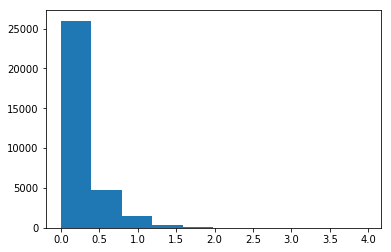

In [30]:
plt.hist(cross_ent.numpy().flatten())

(array([2., 0., 2., 0., 5., 3., 5., 7., 5., 3.]),
 array([-84.84741 , -82.903275, -80.95913 , -79.014984, -77.07085 ,
        -75.12671 , -73.18256 , -71.23842 , -69.29428 , -67.35014 ,
        -65.406   ], dtype=float32),
 <a list of 10 Patch objects>)

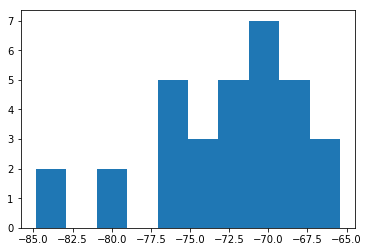

In [31]:
plt.hist(logpz.numpy().flatten())

(array([1., 0., 2., 2., 3., 4., 3., 6., 7., 4.]),
 array([-82.91288 , -80.865555, -78.81824 , -76.77092 , -74.723595,
        -72.67627 , -70.62895 , -68.581635, -66.53431 , -64.486984,
        -62.439667], dtype=float32),
 <a list of 10 Patch objects>)

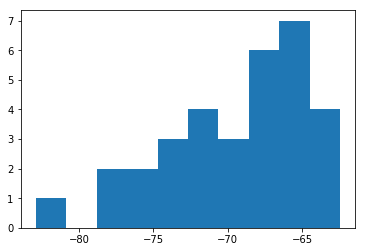

In [33]:
plt.hist(logqz_x.numpy().flatten())

In [37]:
mean, logvar = model.encode(x)
z = model.reparameterize(mean, logvar)
x_logit = model.decode(z)

cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
logpz = log_normal_pdf(z, 0.0, 0.0)
logqz_x = log_normal_pdf(z, mean, logvar)


In [38]:
logpx_z

<tf.Tensor: id=688481, shape=(32,), dtype=float32, numpy=
array([-197.3857 , -243.19565, -303.54773, -191.88618, -229.15714,
       -229.6207 , -314.45468, -285.1949 , -218.64703, -341.0669 ,
       -274.618  , -202.6472 , -307.15924, -225.9649 , -309.81424,
       -322.5646 , -377.58493, -308.30368, -182.12994, -281.25644,
       -192.05067, -173.2295 , -206.34949, -200.24083, -233.37466,
       -316.40656, -185.93338, -166.89844, -186.42786, -214.66818,
       -215.03249, -203.21634], dtype=float32)>

In [39]:
logpz

<tf.Tensor: id=688497, shape=(32,), dtype=float32, numpy=
array([-77.49492 , -92.789185, -76.409744, -72.86847 , -79.002106,
       -68.2383  , -74.35974 , -69.39043 , -79.59485 , -74.40982 ,
       -63.67874 , -75.36171 , -68.050156, -66.268364, -75.33476 ,
       -73.39188 , -67.69509 , -74.745636, -67.79562 , -72.7684  ,
       -66.48019 , -72.02146 , -72.11678 , -81.85683 , -72.351364,
       -64.73198 , -66.48156 , -77.377945, -70.751015, -72.04236 ,
       -69.60476 , -81.026276], dtype=float32)>

In [40]:
z

<tf.Tensor: id=688370, shape=(32, 50), dtype=float32, numpy=
array([[-0.8126807 , -1.2251613 , -0.36968398, ..., -0.5970905 ,
         2.2697268 , -0.76009995],
       [-0.27193964, -1.0021662 ,  1.009647  , ...,  0.43728936,
         0.23948926, -1.3911908 ],
       [-0.03760162,  1.3870878 , -1.2534192 , ..., -1.0410115 ,
        -0.7377871 ,  1.4309355 ],
       ...,
       [-2.012885  ,  0.03598471, -0.04899397, ...,  1.1184605 ,
        -1.2355984 , -0.6130985 ],
       [ 0.5040688 ,  1.5041668 ,  0.26309216, ..., -0.4037794 ,
        -0.16244003,  0.35374138],
       [-0.8822113 ,  1.2827473 ,  0.92670465, ..., -1.7258861 ,
         2.0802548 ,  0.42218146]], dtype=float32)>

In [41]:
mean

<tf.Tensor: id=688358, shape=(32, 50), dtype=float32, numpy=
array([[-0.3938238 , -0.03577803,  0.37855655, ..., -0.35521594,
         0.08915836, -0.13934267],
       [-0.390036  , -0.03272221,  0.37168112, ..., -0.34469348,
         0.08834762, -0.13948154],
       [-0.38190025, -0.02970436,  0.3626397 , ..., -0.33569062,
         0.08557101, -0.13679561],
       ...,
       [-0.39438945, -0.03599536,  0.37853435, ..., -0.35213146,
         0.08966742, -0.14365381],
       [-0.39354503, -0.0342094 ,  0.37581602, ..., -0.3482781 ,
         0.08998496, -0.14326227],
       [-0.3926152 , -0.03302694,  0.37434372, ..., -0.3471073 ,
         0.08943927, -0.1414921 ]], dtype=float32)>

In [42]:
logvar

<tf.Tensor: id=688359, shape=(32, 50), dtype=float32, numpy=
array([[ 0.11882215,  0.017123  , -0.05536831, ..., -0.00178223,
        -0.08721322,  0.13918066],
       [ 0.11560477,  0.01419175, -0.05890729, ..., -0.00123325,
        -0.08606967,  0.1306617 ],
       [ 0.11219626,  0.0127285 , -0.05467835, ..., -0.00203706,
        -0.08467927,  0.12882599],
       ...,
       [ 0.11816175,  0.01571248, -0.06001366, ..., -0.00083432,
        -0.08623979,  0.13728562],
       [ 0.11768342,  0.01458759, -0.05760603, ..., -0.00078847,
        -0.08594178,  0.1353859 ],
       [ 0.11725586,  0.01413046, -0.05614642, ..., -0.00081089,
        -0.08594774,  0.13434753]], dtype=float32)>

In [43]:
logqz_x

<tf.Tensor: id=688511, shape=(32,), dtype=float32, numpy=
array([-74.42707 , -87.964836, -72.63279 , -69.2239  , -79.896286,
       -64.590744, -68.33272 , -63.16898 , -74.18458 , -66.22742 ,
       -59.708065, -71.44935 , -68.26196 , -67.09903 , -69.68206 ,
       -66.58154 , -64.45003 , -71.73127 , -65.329025, -73.022064,
       -64.908615, -72.33321 , -68.70187 , -78.24109 , -73.93671 ,
       -65.29988 , -64.612564, -72.76051 , -67.6042  , -65.54931 ,
       -66.834946, -79.846146], dtype=float32)>